### CSCI E-108 Data Mining, Discovery, and Exploration Final Project Report
Alex Coward\
Spring Term 2024

### 1. Project Overview

For my final project I am using air pollution data from OpenAQ (https://openaq.org/) to investigate clustering and dimensionality reduction techniques to attempt to find clusters of locations around the world based on air pollution measurements. My hypothesis is that there are locations around the world that are similar to each other in terms of their air pollution, and that clustering can be used to find groups of similar locations. If clustering techniques can help more easily identify similar locations, policy makers can look to implement similar strategies to combat similar problems. If clustering can help identify similar locations, we could then use past data to find locations that used to be similar but have now diverged. For locations that used to be clustered together in a problematic, high-pollution cluster, any movement of some of those locations to a better, healthier cluster would potentially help identify potential improvements that could be applied in the still-unhealthy location. In my present analysis I will focus on clustering based on recent data, to test out if clustering using the OpenAQ platform can help identify clusters of locations. In the future this could be enhanced by performing inter-temporal clustering.


One of the primary challenges I have found is that, while OpenAQ includes air quality measurement data for ~17k locations around the globe across 64 parameters, there is a wide discrepancy across the locations in terms of what is reported. Ideally there would be more complete and consistent reporting. Despite this, I was able to use various clustering methods coupled with dimensionality reduction techniques to view location clusters around the globe for 6 of the most significant air quality parameters. My analysis was done for the components used to determine the widely used air quality index (AQI): Ozone (O3), PM2.5 and PM10 particulate matter, Carbon Monoxide (CO), Sulphur Dioxide (SO2) and Nitrogen Dioxide (NO2). In doing so for the recent month of March 2024 I was able to get data from 1,044 locations to be used in my analysis. I also experimented with various smaller subsets of parameters, and another possible avenue for future work would be to investigate further with different parameter groupings.

### 2a. Install PySpark and Spark Dependencies

In my implementation, downloaded air quality measurements for the various locations are each output to a separate JSON file so that not all data is lost if there is an inability to download data for a given location. PySpark is then used to read the separate JSON files into a single dataframe which is then saved in the memory-efficient Parquet format. I allocate a large amount of RAM to Spark given the large amount of data that I download. I used a high-ram CPU-only instance on Google Colab to run my code.

In [ ]:
# code adapted from
# https://colab.research.google.com/github/abhibee/tensorflow/blob/master/run_spark_on_colab.ipynb

!apt-get update # Update apt-get repository
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Spark
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()

# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "16g").getOrCreate()
spark

###2b. Installations and Imports


In [ ]:
! pip install umap
! pip install umap-learn
! pip install scikit-learn-extra

import umap
from sklearn_extra.cluster import CLARA, KMedoids, CommonNNClustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from requests.adapters import HTTPAdapter, Retry
import json
import os
import numpy.random as nr
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### 3. Countries, Parameters and Locations Data Downloads

In addition to air quality measurements OpenAQ also has data describing the countries, pollution parameters, and reporting locations for which measurements are available. For initial EDA, I downloaded country, location, and parameter data to determine what measurement data is needed to perform the analysis. I did this using the OpenAQ API and the Python Requests library, which I also used to download the actual air pollution measurements. The API key listed below was discontinued prior to publishing this report. Cells that would download data, here and further down when the measurements are downloaded, are not run in this version of the notebook since it would overwrite data already saved to disk.

**Header used for all API calls**

In [ ]:
headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "X-API-Key":"a65766aa56345d2d439f789a1456fcf4e94c834b8c201b974eefdacade0362c8"}

**Country Data Download**

In [ ]:
url = "https://api.openaq.org/v2/countries?limit=1000&page=1&offset=0&sort=asc&order_by=name"
response = requests.get(url, headers=headers)
data = response.json().get('results', [])
with open('/content/drive/MyDrive/data_mining_project/openaq_countries.json', 'w') as file:
    json.dump(data, file)

**Parameters Data Download**

In [ ]:
url = "https://api.openaq.org/v2/parameters?limit=100&page=1&offset=0&sort=asc&order_by=id"
response = requests.get(url, headers=headers)
data = response.json().get('results', [])
with open('/content/drive/MyDrive/data_mining_project/openaq_parameters.json', 'w') as file:
    json.dump(data, file)

**Locations Data Download**

The locations data was prone to issues when I tried to download the data all at once and so I downloaded data in smaller chunks.

In [ ]:
def download_locations_data(params, headers):

    all_data = []
    url = 'https://api.openaq.org/v3/locations'

    while True:
        response_data = requests.get(url, headers=headers, params=params)
        results = response_data.json().get('results', [])
        all_data.extend(results)

        if len(results) < params['limit']:
            break

        params['page'] += 1

    with open(f'/content/drive/MyDrive/data_mining_project/openaq_locations_test.json', 'w') as file:
        json.dump(all_data, file)

    return

In [ ]:
params = {
    'page' : 1,
    'limit' : 100
    }

download_locations_data(params=params, headers=headers)

### 4a. Countries and Parameters Data EDA

**Countries EDA**

The country data shows a wide range of the number of reporting locations by country as well as significant differences in terms of the parameters being reported and the date of the most recent data update.

In [ ]:
countries_df = pd.read_json('/content/drive/MyDrive/data_mining_project/openaq_countries.json')

In [ ]:
countries_df.sort_values('locations', ascending=False).head()

,code,name,locations,firstUpdated,lastUpdated,parameters,count,cities,sources
109,US,United States of America,3898,2016-01-30 01:00:00+00,2024-04-30 13:06:30.937+00,"[bc, co, co2, humidity, no, no2, nox, o3, pm1,...",232842350,775,11
17,CN,China,1870,2016-01-01 01:00:00+00,2024-04-30 13:00:00+00,"[co, no2, o3, pm1, pm10, pm25, relativehumidit...",170516639,18,19
47,JP,Japan,1536,2023-07-14 17:00:00+00,2024-04-30 12:00:00+00,"[co, no, no2, nox, pm25, so2, temperature]",34099242,1,3
31,FR,France,792,2016-11-17 23:00:00+00,2024-04-30 13:00:00+00,"[co, humidity, no, no2, o3, pm1, pm10, pm25, p...",45920988,418,9
46,IT,Italy,742,2016-11-21 12:00:00+00,2024-04-30 13:00:00+00,"[co, no, no2, nox, o3, pm1, pm10, pm25, relati...",24755907,584,8


In [ ]:
countries_df.describe()

,locations,count,cities,sources
count,113.000000,1.130000e+02,113.000000,113.000000
mean,152.522124,9.585243e+06,38.371681,3.238938
std,448.049385,3.029280e+07,108.418847,2.670187
min,1.000000,6.600000e+01,0.000000,1.000000
25%,2.000000,3.334500e+04,1.000000,1.000000
50%,12.000000,3.130590e+05,3.000000,3.000000
75%,91.000000,4.644544e+06,21.000000,4.000000
max,3898.000000,2.328424e+08,775.000000,19.000000


While as of 4/30/24 most countries had their most recent data being reported on that day, there are several countries that had not reported data recently.


In [ ]:
countries_df.dtypes

code            object
name            object
locations        int64
firstUpdated    object
lastUpdated     object
parameters      object
count            int64
cities           int64
sources          int64
dtype: object

In [ ]:
countries_df['firstUpdated'] = pd.to_datetime(countries_df['firstUpdated'],format='ISO8601', utc=True)
countries_df['lastUpdated'] = pd.to_datetime(countries_df['lastUpdated'],format='ISO8601', utc=True)

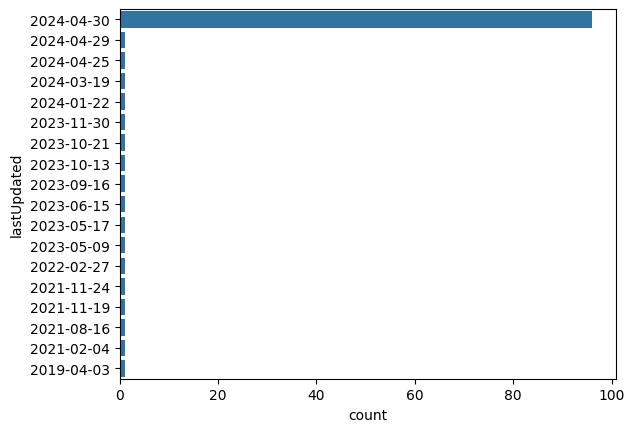

In [ ]:
sorted_dates = sorted(countries_df.lastUpdated.dt.date.unique(), reverse=True)
sns.countplot(countries_df.lastUpdated.dt.date, order=sorted_dates);

In [ ]:
countries_df.lastUpdated.describe(percentiles=[0.1,0.15,0.25,0.5, 0.75])

count                                    113
mean     2024-02-14 22:55:50.687424768+00:00
min                2019-04-03 21:00:00+00:00
10%                2023-10-29 09:36:00+00:00
15%                2024-04-30 08:18:00+00:00
25%                2024-04-30 12:00:00+00:00
50%                2024-04-30 13:00:00+00:00
75%                2024-04-30 13:00:00+00:00
max                2024-04-30 14:00:00+00:00
Name: lastUpdated, dtype: object

For the purpsoes of this report I used data for March 2023, and so I only considered locations that had their last reported data on or after March 31st, 2024. This reduced the number of countries from 113 to 98.

In [ ]:
cutoff_date = '2024-03-31'

In [ ]:
recent_countries = countries_df[(countries_df['lastUpdated'] >= cutoff_date)]

In [ ]:
recent_countries.describe()

,locations,count,cities,sources
count,98.000000,9.800000e+01,98.000000,98.000000
mean,170.724490,1.073884e+07,43.265306,3.510204
std,477.525317,3.233004e+07,115.447810,2.755482
min,1.000000,3.048000e+03,0.000000,1.000000
25%,4.000000,5.838375e+04,1.000000,2.000000
50%,19.000000,5.936745e+05,4.000000,3.000000
75%,95.750000,5.356504e+06,25.250000,4.000000
max,3898.000000,2.328424e+08,775.000000,19.000000


**Parameters EDA**

A wide range also exists for the number of pollution parameters reported in each country, with most countries reporting 12 or fewer parameters of the total of 64 parameters available on the OpenAQ platform. To keep the features consistent across reporting location, I selected a subset of parameters to use as features. The top 6 parameters in terms of the number of countries reporting them are PM10, PM2.5, NO2, O3, SO2, and CO, which are the parameters that are used to calculate the widely used AQI Air Quality Index.

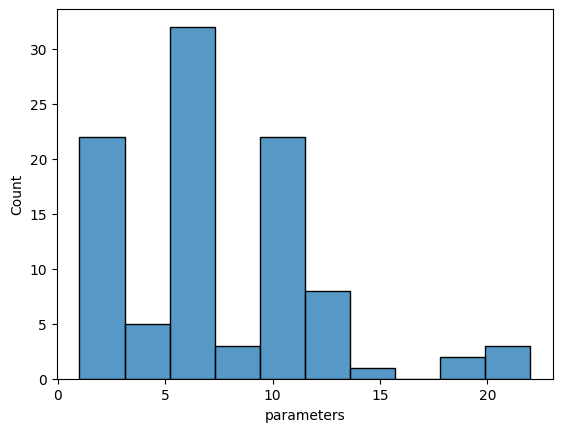

In [ ]:
sns.histplot(recent_countries.parameters.apply(lambda x : len(x)), bins=10);

In [ ]:
recent_countries.explode('parameters')[['name', 'parameters']].groupby('parameters').aggregate('count').sort_values(by='name', ascending=False)

,name
parameters,
pm25,98
pm10,76
no2,66
o3,65
so2,64
co,62
temperature,55
pm1,48
um003,46


It is important to note that the AQI metrics (excluding PM2.5 and PM10) are reported both using ppm and µg/m³. Conversion between these metrics is discussed below in the Location Data EDA section.

In [ ]:
pd.set_option('display.max_colwidth', None)

This code provides a description of the top parameters available on the OpenAQ platform.

In [ ]:
parameters_df = pd.read_json('/content/drive/MyDrive/data_mining_project/openaq_parameters.json')
parameters_df[:10]

,id,name,displayName,description,preferredUnit
0,1,pm10,PM10,Particulate matter less than 10 micrometers in diameter mass concentration,µg/m³
1,2,pm25,PM2.5,Particulate matter less than 2.5 micrometers in diameter mass concentration,µg/m³
2,3,o3,O₃ mass,Ozone mass concentration,µg/m³
3,4,co,CO mass,Carbon Monoxide mass concentration,µg/m³
4,5,no2,NO₂ mass,Nitrogen Dioxide mass concentration,µg/m³
5,6,so2,SO₂ mass,Sulfur Dioxide mass concentration,µg/m³
6,7,no2,NO₂,Nitrogen Dioxide concentration,ppm
7,8,co,CO,Carbon Monoxide concentration,ppm
8,9,so2,SO₂,Sulfur Dioxide concentration,ppm
9,10,o3,O₃,Ozone concentration,ppm


In [ ]:
chosen_parameters = set(['pm25','pm10', 'no2', 'o3', 'so2', 'co'])

This code filters the recently reporting countries to only include those that report all 6 of the AQI parameters.

In [ ]:
country_subset = recent_countries[recent_countries['parameters'].apply(lambda x: chosen_parameters.issubset(set(x)))]

There were 57 countries that had reported data after the cutoff that were listed as reporting data for all 6 of the AQI parameters.

In [ ]:
country_subset.describe()

,locations,count,cities,sources
count,57.000000,5.700000e+01,57.000000,57.000000
mean,260.824561,1.770956e+07,72.315789,4.526316
std,578.262333,4.088922e+07,144.934364,3.059559
min,4.000000,1.695900e+04,1.000000,1.000000
25%,24.000000,7.767760e+05,5.000000,3.000000
50%,75.000000,3.206180e+06,17.000000,4.000000
75%,317.000000,1.286999e+07,61.000000,5.000000
max,3898.000000,2.328424e+08,775.000000,19.000000


###4b. Location Data EDA

To finalize data selection prior to downloading the actual measurement data, I analysed the location data for the given dates and parameters to get a list of locations to download data for. I also analysed the units provided for measurement data by location and found that conversions between µg/m³ and ppm are necessary.

In [ ]:
locations_df = pd.read_json('/content/drive/MyDrive/data_mining_project/openaq_locations.json')

There were 16,978 total reporting locations available from OpenAQ.

In [ ]:
len(locations_df)

16978

Looking at the locations data I found that the data for the parameters and the last date of reported data was nested in dictionaries which needed to be accessed to determine the subset of locations we will download data for.

In [ ]:
locations_df.head(1)

,id,name,locality,timezone,country,owner,provider,isMobile,isMonitor,instruments,sensors,coordinates,licenses,bounds,distance,datetimeFirst,datetimeLast
0,13,"Delhi Technological University, Delhi - CPCB",None,Asia/Kolkata,"{'id': 106, 'code': 'IN', 'name': 'India'}","{'id': 4, 'name': 'Unknown Governmental Organization'}","{'id': 168, 'name': 'CPCB'}",False,True,"[{'id': 2, 'name': 'Government Monitor'}]","[{'id': 13864, 'name': 'pm25 µg/m³', 'parameter': {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'displayName': 'PM2.5'}}, {'id': 13866, 'name': 'no2 µg/m³', 'parameter': {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'displayName': 'NO₂ mass'}}]","{'latitude': 28.744, 'longitude': 77.12}",None,"[77.12, 28.744, 77.12, 28.744]",NaN,"{'utc': '2016-11-02T18:30:00+00:00', 'local': '2016-11-03T00:00:00+05:30'}","{'utc': '2018-02-22T04:00:00+00:00', 'local': '2018-02-22T09:30:00+05:30'}"


In [ ]:
locations_df['parameters'] = locations_df['sensors'].apply(lambda x: [data_dict['parameter']['name'] for data_dict in x])

In [ ]:
locations_df['parameters'][:5]

0                       [pm25, no2]
1    [o3, so2, pm10, pm25, co, no2]
2    [o3, pm10, so2, pm25, co, no2]
3                            [pm25]
4    [co, no2, so2, o3, pm25, pm10]
Name: parameters, dtype: object

In [ ]:
locations_df['parameters_units'] = locations_df['sensors'].apply(lambda x: [data_dict['name'] for data_dict in x])

In [ ]:
locations_df['parameters_units'][:5]

0                                               [pm25 µg/m³, no2 µg/m³]
1    [o3 µg/m³, so2 µg/m³, pm10 µg/m³, pm25 µg/m³, co µg/m³, no2 µg/m³]
2    [o3 µg/m³, pm10 µg/m³, so2 µg/m³, pm25 µg/m³, co µg/m³, no2 µg/m³]
3                                                          [pm25 µg/m³]
4    [co µg/m³, no2 µg/m³, so2 µg/m³, o3 µg/m³, pm25 µg/m³, pm10 µg/m³]
Name: parameters_units, dtype: object

There were 10,218 locations that had their last data reported on or after the cutoff date.

In [ ]:
recent_locations = locations_df[locations_df['datetimeLast'].apply(lambda x: x['utc']) >= cutoff_date]
len(recent_locations)

10218

Filtering the recent reporting locations to those that report data for all 6 of the AQI parameters reduced the relevant reporting locations to 1,256.

In [ ]:
len(recent_locations[recent_locations['parameters'].apply(lambda x: chosen_parameters.issubset(set(x)))])

1256

PM 2.5 and PM 10 are always reported only in µg/m³ due to the composition of particulate matter. For the other AQI parameters, 341 locations reported them in µg/m³ and 922 reported them in ppm with only 7 reporting them in both. To not further reduce the already reduced list of locations, I chose to convert the µg/m³ data-points to ppm. Unfortunately, there were no locations that reported all 6 AQI parameters and also reported temperature and air pressure. This meant that the conversions couldn't be done using local atmospheric conditions at the time of the measurements. I performed the conversion per standard practice, assuming temperature of 25 degrees Celsius and 1 atmospheric pressure at the time of the measurement.

In [ ]:
parameters_ugm3 = set(['pm25 µg/m³','pm10 µg/m³', 'no2 µg/m³', 'o3 µg/m³', 'so2 µg/m³', 'co µg/m³'])
parameters_ppm = set(['pm25 µg/m³','pm10 µg/m³', 'no2 ppm', 'o3 ppm', 'so2 ppm', 'co ppm'])

In [ ]:
# limit recent locations to those reporting all 6 AQI parameters in µg/m³
ugm3_locations = recent_locations[recent_locations['parameters_units'].apply(lambda x: parameters_ugm3.issubset(set(x)))]

In [ ]:
len(ugm3_locations)

341

In [ ]:
# limit recent locations to those reporting all 6 AQI parameters in ppm
ppm_locations = recent_locations[recent_locations['parameters_units'].apply(lambda x: parameters_ppm.issubset(set(x)))]

In [ ]:
len(ppm_locations)

922

In [ ]:
len(set(ugm3_locations['id']).intersection(set(ppm_locations['id'])))

7

In [ ]:
# limit recent locations to those reporting all 6 AQI parameters and pressure, temperature
augmented_parameters = set(['pm25','pm10', 'no2', 'o3', 'so2', 'co', 'pressure', 'temperature'])

In [ ]:
len(recent_locations[recent_locations['parameters'].apply(lambda x: augmented_parameters.issubset(set(x)))])

0

In [ ]:
#limit_locations to those recent locatins that report all 6 AQI parameters
locations_subset = recent_locations[recent_locations['parameters'].apply(lambda x: chosen_parameters.issubset(set(x)))]

Interestingly, not only the number of locations but also the location mix changed substantially after reducing the recent locations to only those where the full list of AQI parameters are being reported. Locations in South Korea made up a large proportion of the locations with the desired parameters, which pointed to robust air quality monitoring in use in the country.

In [ ]:
recent_locations.country.apply(lambda x: x['name']).value_counts()

country
United States of America    2489
Japan                       1520
South Korea                  682
Italy                        605
Spain                        593
                            ... 
Sri Lanka                      1
Saudi Arabia                   1
Algeria                        1
Costa Rica                     1
Morocco                        1
Name: count, Length: 98, dtype: int64

In [ ]:
locations_subset.country.apply(lambda x: x['name']).value_counts().head(10)

country
South Korea                 674
Spain                        89
Mexico                       66
Taiwan                       66
Thailand                     50
United States of America     43
Chile                        32
Serbia                       28
Hungary                      28
Poland                       28
Name: count, dtype: int64

###5. Measurement Data Download###

Measurements for each location were downloaded from the API using the location's 'id', and so I created a list of ids for the locations that had their last data reported on or after March 31, 2024 and were listed as reporting data for all 6 AQI parameters.

In [ ]:
location_list = list(locations_subset['id'].sort_values())

Given the large number of location measurements that had to be downloaded, there was a strong likelihood that there would be an API error. To manage this, I implemented a function that I ran iteratively on each location separately, so that an error downloading data for 1 location didn't lead to the loss of all the data downloaded but not yet saved for other locations.

In [ ]:
def download_measurements(location_id, save_folder_path, params, headers):
  data = []
  url = 'https://api.openaq.org/v2/measurements'

  # This code downloads data for a given location a page at a time with retries and adds the data to a list.
  # Once all data is exhausted (len(results < limit), the data is saved to a JSON for the given location.
  while True:
    s = requests.Session()
    retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504, 408])
    s.mount('https://', HTTPAdapter(max_retries=retries))
    response_data = s.get(url, params=params, headers=headers)

    results = response_data.json().get('results', [])
    data.extend(results)

    if len(results) < params['limit']:
        break

    params['page'] += 1

  with open(f'{save_folder_path}/{location_id}.json', 'w') as file:
        json.dump(data, file)

  return

In [ ]:
# Used for calls to download_measurements below
# Code not run in this version of the notebook to avoid re-downloading data
  params = {
    'date_from':'2024-03-01',
    'date_to':'2024-03-31',
    'page':1,
    'limit':1000,
    'parameter':['pm10', 'pm25', 'no2', 'so2', 'co', 'o3']
    }

# Sets the path for saving the measurements data and creates the folder
save_folder_path = '/content/drive/MyDrive/data_mining_project/measurements_data'
os.makedirs(save_folder_path, exist_ok=True)


# This code creates a list of all the locations for which data has been downloaded and compares them to
# the list of locations for which data need to be downloaded to determine the remaining locations.
# In case of interrupted execution, the code can be run again and only the remaining locations will be downloaded.
completed_locations = [os.path.splitext(file)[0] for file in os.listdir(save_folder_path) if file.endswith('.json')]
remaining_locations = list(set([str(x) for x in location_list]).symmetric_difference(set(completed_locations)))

# This code loops through the remaining locations and calls download_measurements on them.
for location in remaining_locations:
  params['location_id'] = location
  download_measurements(location, save_folder_path, params=params, headers=headers)
  print(f"Completed locations: {len([os.path.splitext(file)[0] for file in os.listdir(save_folder_path) if file.endswith('.json')])}")

###6. Measurement Data EDA and Pre-Processing

Given that all the measurements data was saved to separate JSON files, I used PySpark to load them all into a dataframe and to save them into a Parquet file which could then be accessed via Pandas.

In [ ]:
measurements_data = spark.read.json('/content/drive/MyDrive/data_mining_project/measurements_data')

In [ ]:
measurements_data.write.parquet('/content/drive/MyDrive/data_mining_project/measurements_parquet')

In [ ]:
measurements_df = pd.read_parquet('/content/drive/MyDrive/data_mining_project/measurements_parquet')

There were 2,154,573 measurements from the recently reporting locations which report all 6 AQI parameters. These measurements were in narrow format, with each row representing a single measurement taken at a single moment in time for a single parameter and location.

In [ ]:
len(measurements_df)

2154573

As can be seen below, data for all parameters other than PM 2.5 and PM 10 was split across ppm (approx. 2/3 of data) and µg/m³ (approx. 1/3 of data) and so conversions were required. I used the conversion equations provided here https://www.breeze-technologies.de/blog/air-pollution-how-to-convert-between-mgm3-%C2%B5gm3-ppm-ppb/ that assume temperature of 25 degrees Celsius and 1 atmospheric pressure at the time of the measurement.

In [ ]:
measurements_df['parameter_unit'] = measurements_df['parameter'] + ' ' + measurements_df['unit']

In [ ]:
measurements_df['parameter_unit'].value_counts()

parameter_unit
pm10 µg/m³    375599
pm25 µg/m³    373414
o3 ppm        240563
no2 ppm       234467
so2 ppm       233607
co ppm        232781
no2 µg/m³     127571
so2 µg/m³     126430
o3 µg/m³      121202
co µg/m³       88939
Name: count, dtype: int64

In [ ]:
co_conversion_to_ppm = .001/1.15
no2_conversion_to_ppm  = .001/1.88
o3_conversion_to_ppm  = .001/1.96
so2_conversion_to_ppm  = .001/2.62

In [ ]:
measurements_df.loc[measurements_df['parameter_unit'] == 'co µg/m³', 'value'] *= co_conversion_to_ppm
measurements_df.loc[measurements_df['parameter_unit'] == 'no2 µg/m³', 'value'] *= no2_conversion_to_ppm
measurements_df.loc[measurements_df['parameter_unit'] == 'o3 µg/m³', 'value'] *= o3_conversion_to_ppm
measurements_df.loc[measurements_df['parameter_unit'] == 'so2 µg/m³', 'value'] *= so2_conversion_to_ppm

City, entity, isAnalysis, isMobile, sensorType were all either blank or contained a single uninformative value across all measurements and so they were removed. After converting the units, unit and parameter_unit were no longer needed and were also removed. The date column was not used for the present analysis and so it was also removed.

In [ ]:
print(measurements_df.city.value_counts())
print(measurements_df.entity.value_counts())
print(measurements_df.isAnalysis.value_counts())
print(measurements_df.isMobile.value_counts())
print(measurements_df.sensorType.value_counts())
print(measurements_df.unit.value_counts())
print(measurements_df.parameter.value_counts())

Series([], Name: count, dtype: int64)
entity
Governmental Organization    2154573
Name: count, dtype: int64
Series([], Name: count, dtype: int64)
isMobile
False    2154573
Name: count, dtype: int64
sensorType
reference grade    2154573
Name: count, dtype: int64
unit
µg/m³    1213155
ppm       941418
Name: count, dtype: int64
parameter
pm10    375599
pm25    373414
no2     362038
o3      361765
so2     360037
co      321720
Name: count, dtype: int64


In [ ]:
measurements_df.drop(columns=['city', 'entity','isAnalysis', 'isMobile','sensorType', 'unit', 'parameter_unit', 'date'], inplace=True)

While latitude and longitude were not used in the present analysis, this data could prove useful in future analysis and was maintained, though I pulled the latitude and longitude values out of the dictionary structure used by the 'coordinates' column and then deleted the 'coordinates' column.

In [ ]:
measurements_df['latitude'] = measurements_df['coordinates'].apply(lambda x: x['latitude'])
measurements_df['longitude'] = measurements_df['coordinates'].apply(lambda x: x['longitude'])
measurements_df.drop(columns=['coordinates'], inplace=True)

There were a small number of measurements with negative values which made up 0.7% of the total number of measurements. I assumed these were measurement or other data errors and so I removed them.

In [ ]:
len(measurements_df[measurements_df['value'] < 0]) / len(measurements_df)

0.007023665478032074

In [ ]:
measurements_df = measurements_df[measurements_df['value'] >=0]

In [ ]:
len(measurements_df)

2139440

For the purposes of clustering, each row needs need to represent a single location with all the parameters as features (i.e. wide format). This was done by using the groupby DataFrame method to average the parameter values for each unique location and then the pivot_table function to combine all the averaged parameter values for a given location into a single row.

In [ ]:
grouped_measurements = measurements_df.groupby(['locationId', 'location', 'country', 'latitude', 'longitude', 'parameter']).agg('mean').reset_index()
grouped_measurements.sort_values(by='locationId', inplace=True)

In [ ]:
pivot_measurements = grouped_measurements.pivot_table(index=['locationId', 'location', 'latitude', 'longitude', 'country'],
                          columns='parameter',
                          values='value', aggfunc='mean').reset_index()

In [ ]:
pivot_measurements.head()

parameter,locationId,location,latitude,longitude,country,co,no2,o3,pm10,pm25,so2
0,25,Parque O'Higgins,-33.464142,-70.660797,CL,NaN,NaN,NaN,73.606488,21.674189,NaN
1,27,Concón,-32.924568,-71.515399,CL,NaN,NaN,NaN,45.370423,20.915535,0.008508
2,45,Puente Alto,-33.591391,-70.594788,CL,NaN,NaN,NaN,78.672779,25.057489,NaN
3,54,Talagante,-33.673752,-70.953065,CL,NaN,NaN,NaN,56.716502,21.957664,NaN
4,65,Punteras,-36.923330,-73.036132,CL,NaN,NaN,NaN,33.827288,13.932318,0.005737


All parameters show some degree of null values. These null values are due to the location not having reported measurements for the given parameter in March 2024 despite the location data analysed earlier implying that all the relevant parameters are available for these locations. These locations were therefore dropped, leaving the final list of 1,044 locations to use for clustering.

In [ ]:
pivot_measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   locationId  1240 non-null   int64  
 1   location    1240 non-null   object 
 2   latitude    1240 non-null   float64
 3   longitude   1240 non-null   float64
 4   country     1240 non-null   object 
 5   co          1099 non-null   float64
 6   no2         1164 non-null   float64
 7   o3          1164 non-null   float64
 8   pm10        1195 non-null   float64
 9   pm25        1205 non-null   float64
 10  so2         1156 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 106.7+ KB


In [ ]:
pivot_measurements.dropna(how='any', inplace=True)

In [ ]:
pivot_measurements.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 6 to 1238
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   locationId  1044 non-null   int64  
 1   location    1044 non-null   object 
 2   latitude    1044 non-null   float64
 3   longitude   1044 non-null   float64
 4   country     1044 non-null   object 
 5   co          1044 non-null   float64
 6   no2         1044 non-null   float64
 7   o3          1044 non-null   float64
 8   pm10        1044 non-null   float64
 9   pm25        1044 non-null   float64
 10  so2         1044 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 97.9+ KB


To help with analysis, the full country name was added for each location. A large proportion of the locations are in South Korea, which is in line with what we saw when analysing the location data.

In [ ]:
pivot_measurements = pd.merge(pivot_measurements, countries_df[['code','name']], left_on='country', right_on='code', how='left').drop(columns='country')

In [ ]:
pivot_measurements.rename(columns={'code':'country_code', 'name':'country_name'}, inplace=True)

In [ ]:
pivot_measurements.country_name.value_counts()

country_name
South Korea                 670
Taiwan                       65
Spain                        64
Mexico                       34
United States of America     30
Serbia                       28
Thailand                     24
Hungary                      20
Poland                       16
Germany                      11
China                        11
Italy                         7
Kosovo                        7
Macedonia                     6
Austria                       6
Cyprus                        5
Belgium                       5
Peru                          5
North Korea                   4
Czechia                       4
Portugal                      3
Canada                        3
Bulgaria                      2
France                        2
Lithuania                     2
Vietnam                       2
Greece                        2
Luxembourg                    1
Myanmar                       1
Laos                          1
Argentina                  

The wide tables were saved to disk as Parquet files.

In [ ]:
os.makedirs('/content/drive/MyDrive/data_mining_project/pivot_measurements', exist_ok=True)
pivot_measurements.to_parquet('/content/drive/MyDrive/data_mining_project/pivot_measurements/pivot_measurements_table')

In [ ]:
measurements_df = pd.read_parquet('/content/drive/MyDrive/data_mining_project/pivot_measurements/pivot_measurements_table')

The histograms for the log of the measurements appeared to be approximately normal, which would make the measurements themselves lognormal. While this isn't the same as the data being normally distributed, it seemed closer to normal than to uniform, and so using the standard scaling was used instead of min-max scaling to scale and normalize the data prior to performing clustering.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


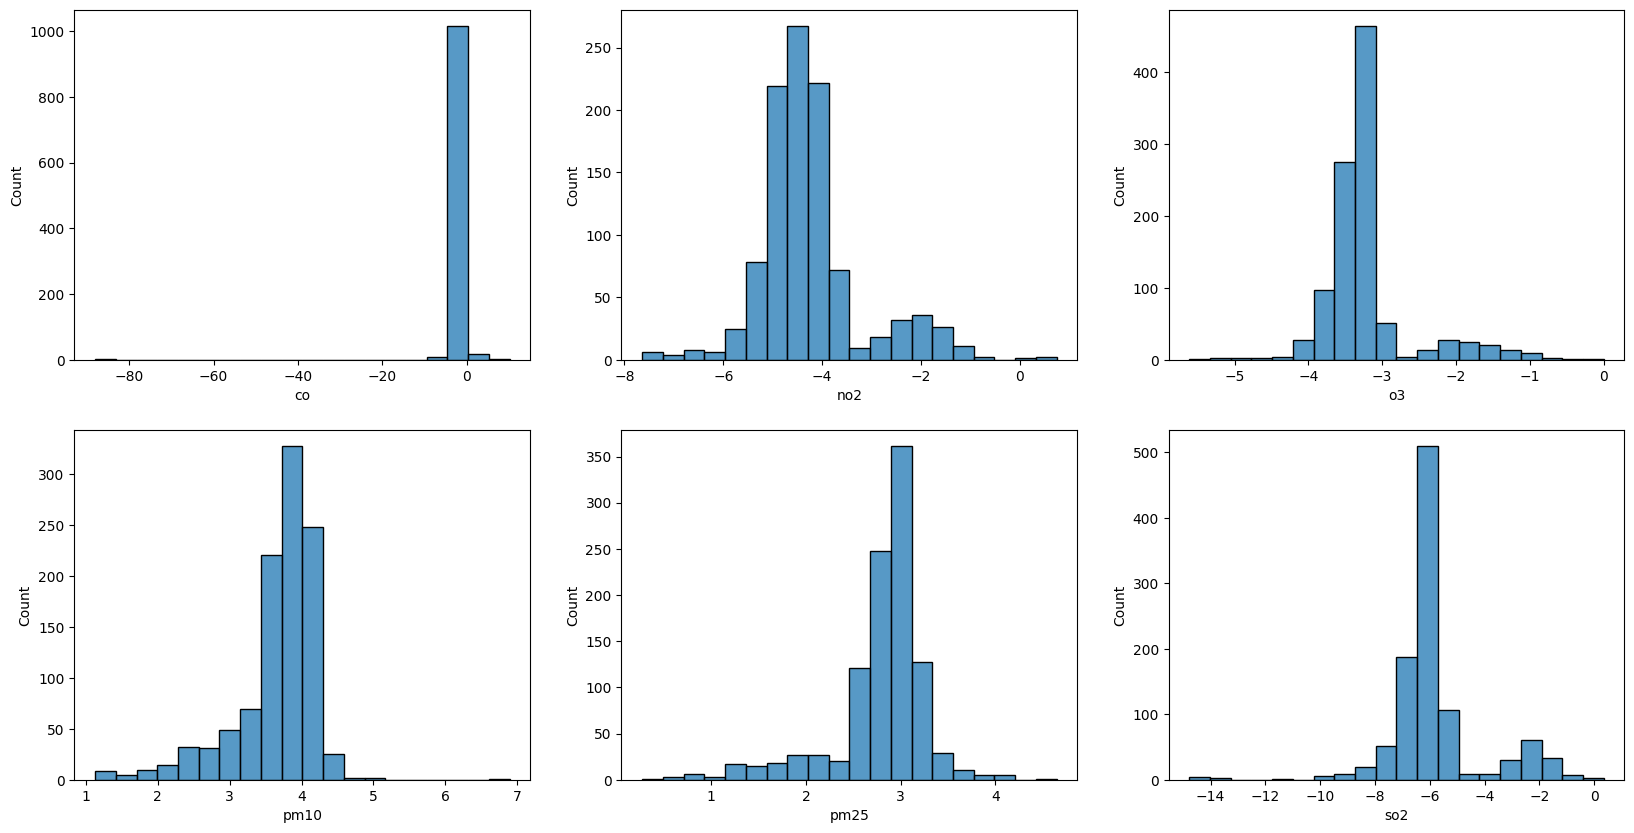

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20, 10))
ax = ax.flatten()

for i, col in enumerate(measurements_df.columns[4:10]):
  sns.histplot(np.log(measurements_df[col]), bins=20, ax=ax[i])
plt.show();

In [ ]:
# This code normalizes the data using sklearn's standard scaler
all_cols = ['pm25','pm10', 'no2', 'o3', 'so2', 'co']

measurements_standard = measurements_df.copy()
measurements_standard.loc[:,all_cols] = StandardScaler().fit_transform(measurements_standard.loc[:,all_cols])

###7. Dimensionality Reduction

Each location is represented as a 6-dimensional data point, which means the reporting locations live in a 6-dimensional space. Clustering algorithms can be implemented on 6-dimensional data, but to visualize the clusters the data needs to be projected down to a number of dimensions that we can view. t-SNE and UMAP are two methods that reduce the dimensionality in a way that allows us to view a 2-dimensional representation of the data. When we perform clustering, this 2-dimensional representation permits seeing if the clustering seems to separate clusters well in the 2-dimensional representation space. As we are only visualizing a 2-dimensional representation of 6-dimensional data, it is possible that data that clusters that do not seem separate in 2 dimensions would be separated in higher dimensions. The initial t-SNE and UMAP plots prior to clustering show that while the data covers many countries, South Korea makes up a large share of the data and the data points for South Korea appear relatively close together.

In [ ]:
# code adapted from code in course clustering assignment
np.random.seed(1)
tsne_measurements = TSNE().fit_transform(measurements_standard.iloc[:,4:10])

In [ ]:
# code adapted from code in course clustering assignment
np.random.seed(4365)
reducer = umap.UMAP()
umap_measurements = reducer.fit_transform(measurements_standard.iloc[:,4:10])

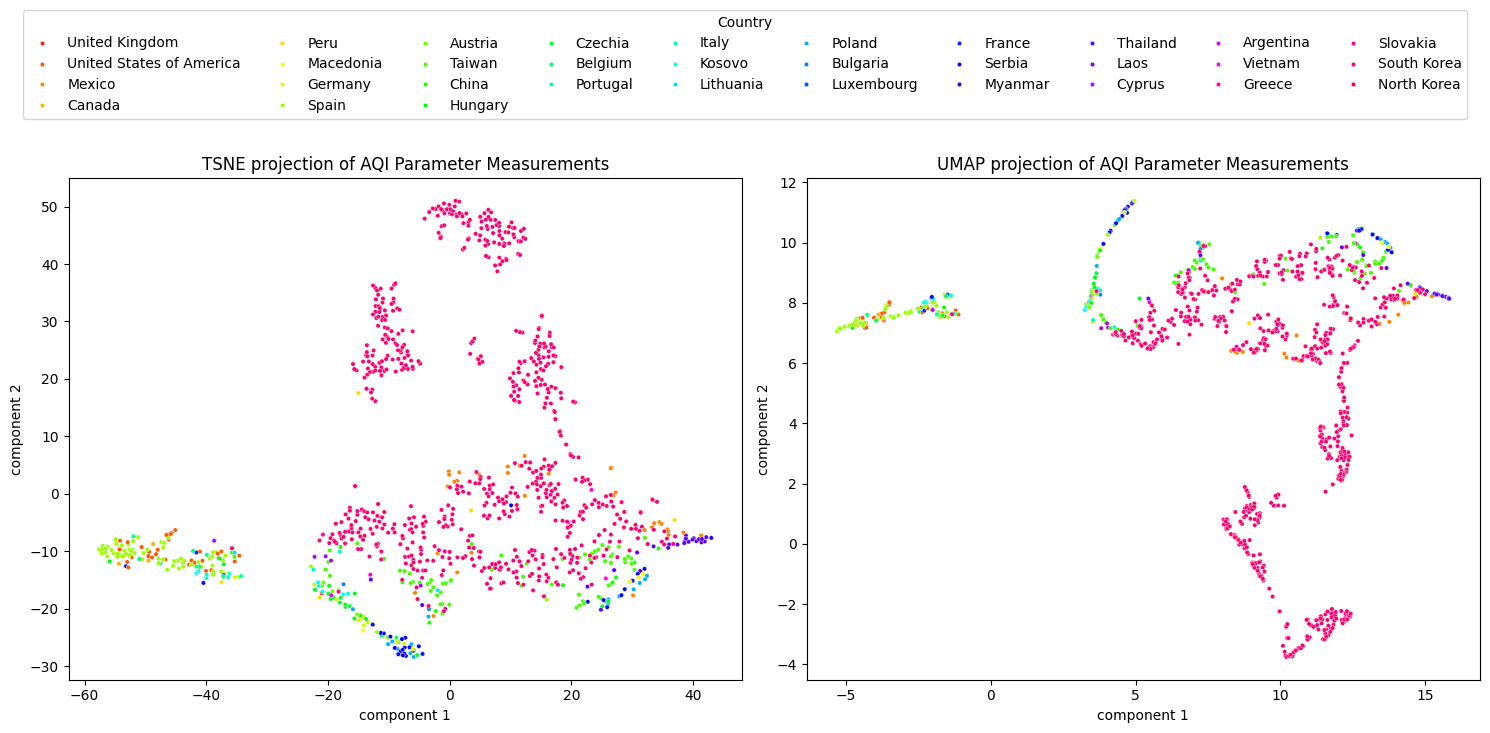

In [ ]:
# code adapted from code in course clustering assignment
tsne_measurements_df = pd.DataFrame(tsne_measurements, columns = ['component1', 'component2'])
tsne_measurements_df['country_name'] = measurements_standard['country_name']

umap_measurements_df = pd.DataFrame(umap_measurements, columns = ['component1', 'component2'])
umap_measurements_df['country_name'] = measurements_standard['country_name']

palette = sns.color_palette("hsv", len(umap_measurements_df['country_name'].unique()))

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax = ax.flatten()

sns.scatterplot(data=tsne_measurements_df, x='component1', y='component2',
                hue='country_name', palette=palette, s=10, ax=ax[0]).legend_.remove();
ax[0].set_xlabel('component 1');
ax[0].set_ylabel('component 2');
ax[0].set_title('TSNE projection of AQI Parameter Measurements');

sns.scatterplot(data=umap_measurements_df, x='component1', y='component2',
                hue='country_name', palette=palette, s=10, ax=ax[1]).legend_.remove();
ax[1].set_xlabel('component 1');
ax[1].set_ylabel('component 2');
ax[1].set_title('UMAP projection of AQI Parameter Measurements');

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           fancybox=True, ncol=10, title='Country')

plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

###8a. K-means Clustering

The K-means clustering algorithm starts from a pre-determined number of clusters K and iteratively reassigns cluster centers and cluster members. Cluster centers are the mean of the values of the members of a cluster, and at each iteration members are reassigned to the cluster center that is closest to them and the mean is recalculated based on this new cluster member assignment. The main hyperparameter for the algorithm is the number of clusters K. The algorithm used is a greedy one that makes changes based on what is the locally optimal assignment at each step. In this way, different initializations can produce different results, and therefore the algorithm is generally run with several initializations and the one with the lowest within cluster sum of squared distance (WCSS) is chosen.

To determine the optimal number of clusters, the algorithm can be run several times and metrics for clustering quality can be looked at to attempt to decide which is the best number K. This process is similar for other clustering methods that require specifying a number of clusters.

 One method for determining the number of clusters is to search for an "elbow" in the graph of WCSS and the graph of between cluster sum of squared distance (BCSS), with both metrics plotted against the number of clusters. An elbow indicates that the WCSS, which monotonically decreases as you increase the number of clusters, has slowed its rate of decrease. For BCSS, which monotonically increases as you increase the number of clusters, the elbow indicates that the rate of increase has slowed.

 Other methods include looking for a peak in the silhouette score and the Calinski-Harabasz Score, given that higher values of these metrics imply better clusters.

 Ideally these metrics would point to a consistent, best K for the clustering algorithm, but as seen below, this is not always the case.


In [ ]:
# code adapted from course clustering assignment
def plot_cluster_assignments(tsne_df, umap_df, cluster_assignments):
    fig, ax = plt.subplots(1,2,figsize=(15,7))
    ax = ax.flatten()
    tsne_df['cluster_assignments'] = cluster_assignments.astype('category')
    sns.scatterplot(data=tsne_df, x='component1', y='component2',
                    hue='cluster_assignments', s=10, ax=ax[0]).legend_.remove();
    ax[0].set_xlabel('component 1');
    ax[0].set_ylabel('component 2');
    ax[0].set_title(f't-SNE projection of cluster assignments for AQI Parameter Measurements');

    umap_df['cluster_assignments'] = cluster_assignments.astype('category')
    sns.scatterplot(data=umap_df, x='component1', y='component2',
                    hue='cluster_assignments', s=10, ax=ax[1]).legend_.remove();
    ax[1].set_xlabel('component 1');
    ax[1].set_ylabel('component 2');
    ax[1].set_title(f'UMAP projection of cluster assignments for AQI Parameter Measurements');

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
           fancybox=True, ncol=len(set(cluster_assignments)), title='Cluster')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
# code adapted from course clustering assignment
def cluster_search_kmeans(df, nclusts=(3,21), n_init=10):
    ## If there are cluster assignments in the data frame remove them.
    if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
    WCSS=[]
    BCSS=[]
    silhouette=[]
    CH_index = []
    ## Compute total sum of squares
    x_bar = np.mean(df, axis=0)
    TSS = np.sum(np.sum(np.square(df - x_bar)))
    for n in range(nclusts[0],nclusts[1]+1):
        temp_model = KMeans(n_clusters=n, n_init=n_init).fit(df)
        WCSS.append(temp_model.inertia_)
        BCSS.append(TSS - temp_model.inertia_)
        assignments = temp_model.predict(df)
        silhouette.append(silhouette_score(df, assignments))
        CH_index.append(calinski_harabasz_score(df, assignments))
    _, ax = plt.subplots(2,2, figsize=(8,8))
    ax = ax.flatten()
    ax[0].plot(range(nclusts[0],nclusts[1]+1),WCSS)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    ax[1].plot(range(nclusts[0],nclusts[1]+1),BCSS)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    ax[2].plot(range(nclusts[0],nclusts[1]+1),silhouette)
    ax[2].set_xlabel('Number of clusters')
    ax[2].set_ylabel('Silhouette Score')
    ax[3].plot(range(nclusts[0],nclusts[1]+1),CH_index)
    ax[3].set_xlabel('Number of clusters')
    ax[3].set_ylabel('Calinski Harabasz Score')
    plt.tight_layout()

    return pd.DataFrame({'NumberClusters':range(nclusts[0],nclusts[1]+1),
                         'Silhouette':silhouette})


Looking at the metrics for K-means clustering on our data does not provide a consistent picture. WCCS and BCCS seem to have an elbow at around 7 or 8 clusters. The Calinski-Harabasz Score increases for all Ks. The silhouette score starts out high and drops, with a local maximum at 9. Based on these results, somewhere between 7 and 9 clusters seems ideal, and after trying out 7, 8, and 9, 9 seemed best when viewed in the t-SNE and UMAP plots, though the result isn't great.

,NumberClusters,Silhouette
0,3,0.874945
1,4,0.602381
2,5,0.293456
3,6,0.297903
4,7,0.345790
5,8,0.388732
6,9,0.404063
7,10,0.345442
8,11,0.344572
9,12,0.357083


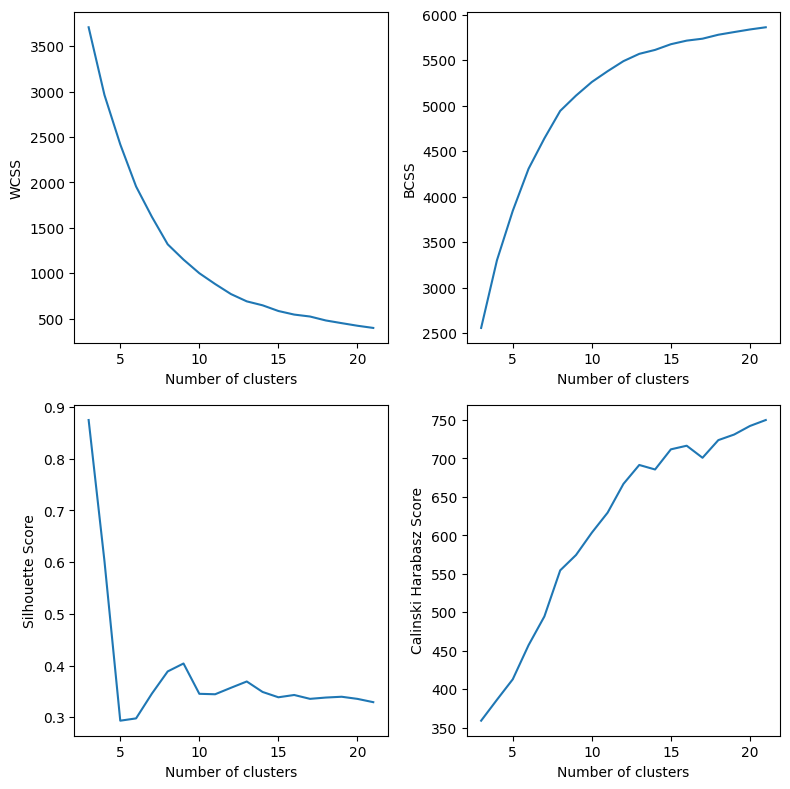

In [ ]:
nr.seed(9966)
cluster_search_kmeans(measurements_standard.iloc[:,4:10])

In [ ]:
nr.seed(4455)
measurements_standard['cluster_assignments'] = KMeans(n_clusters=9, n_init=10).fit_predict(measurements_standard.iloc[:,4:10])

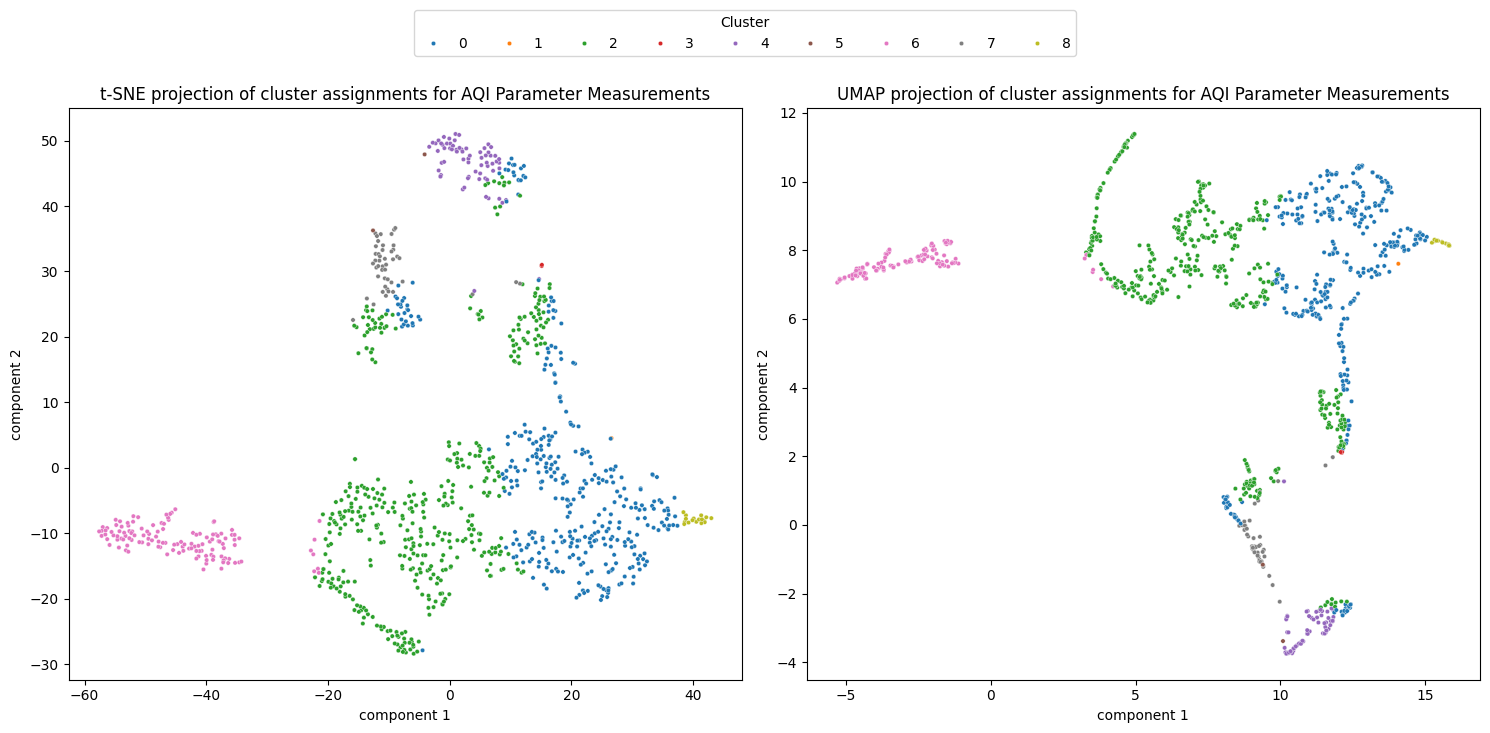

In [ ]:
plot_cluster_assignments(tsne_measurements_df, umap_measurements_df, measurements_standard['cluster_assignments'])

###8b. Agglomerative Clustering

Agglomerative clustering starts with each data point separated into its own cluster. At each step it calculates the distance between clusters and then joins the two clusters that are closest to each other into a single cluster. It does this iteratively until all data points are in a single cluster.

The practitioner then must decide which number of clusters to use, with silhouette score serving as the primary tool for deciding the best number of clusters.

 There are 2 hyperparameters: 1) the distance metric (e.g. L1, L2, cosine) and 2) the linkage, which determines how the distance is calculated (e.g. complete sets the distance to the max distance between a point in each cluster, single sets it to the minimum, average uses the average across each cluster, ward minimizes the variance of the newly created cluster).

After experimenting with all the possible hyperparameters, I found that the average linkage coupled with cosine distance was the setting that made it easiest to find a clearly superior number of clusters. After this, complete linkage with cosine distance also provided decent results, while all other linkages and distance metrics did not work well.

In [ ]:
# code adapted from code in course clustering assignment
def find_max_diameter(df, metric='cosine'):
    max_diameters = []
    ## Put your code below
    for i in df.loc[:,'cluster_assignments'].unique():
        temp = df[df.loc[:,'cluster_assignments']==i].drop(columns='cluster_assignments')
        max_diameters.append(np.amax(pairwise_distances(temp, metric=metric)))
    return np.amax(max_diameters)

def evaluate_agglomerative_clusters(df, metric='cosine', linkage='average', nclusts=(2,18)):
    silhouette_coefficients = []
    max_diameters = []
    for k in range(nclusts[0],nclusts[1]+1):
        ## Put your code below
        ## First compute the cluster assignmenets for the number of clusters, k
        if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
        temp_mod=AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=metric,
                                         compute_full_tree=False)
        cluster_assignments = temp_mod.fit_predict(df)

        ## Compute and append the silhouette coefficeint to the list
        silhouette_coefficients.append(silhouette_score(df, cluster_assignments, metric=metric))

        ## Find the max diameter of the clusters
        ## First add the cluster assignment column to the data frame
        df['cluster_assignments'] = cluster_assignments
        max_diameters.append(find_max_diameter(df, metric=metric))

    ## Plot the results
    _, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(range(nclusts[0],nclusts[1]+1), max_diameters);
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Maximum cluster diameter')
    ax[0].set_title('Maximum cluster diameter vs. number of clusters')
    ax[1].plot(range(nclusts[0],nclusts[1]+1), silhouette_coefficients);
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Coefficients')
    ax[1].set_title('Silhouette coefficient vs. number of clusters')
    return pd.DataFrame({'NumberClusters':range(nclusts[0],nclusts[1]+1),
                         'ClusterDiameter':max_diameters ,
                         'SilhouetteCoefficient':silhouette_coefficients})

,NumberClusters,ClusterDiameter,SilhouetteCoefficient
0,2,1.991257,0.347992
1,3,1.977590,0.494451
2,4,1.977590,0.545036
3,5,1.675603,0.629409
4,6,1.675603,0.589252
5,7,1.675603,0.484184
6,8,1.675603,0.472184
7,9,1.556404,0.477373
8,10,1.556404,0.472512
9,11,1.556404,0.523973


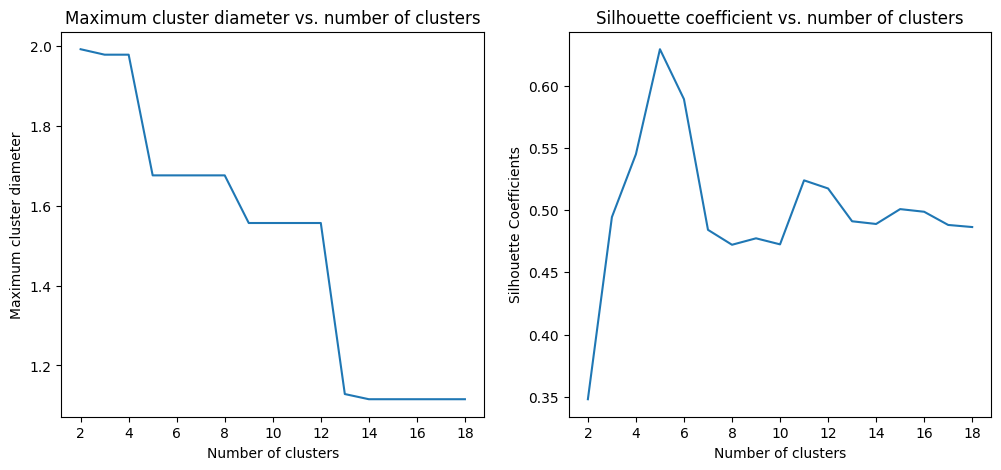

In [ ]:
evaluate_agglomerative_clusters(measurements_standard.iloc[:,4:10])

In [ ]:
# code adapdted from course clustering assignment
nr.seed(2356)
if 'cluster_assignments' in measurements_standard.columns: measurements_standard.drop(columns='cluster_assignments', inplace=True)
model_agglomerative =  AgglomerativeClustering(n_clusters=5, linkage='average', metric='cosine',
                                              compute_full_tree=False)
measurements_standard['cluster_assignments'] = model_agglomerative.fit_predict(measurements_standard.iloc[:,4:10])


The clusters shown below seem much better than those achieved by K-Means. Given that Agglomerative Clustering with euclidean distance performed poorly, it seems reasonable that K-means, which uses euclidean distance, should produce sub-optimal results.

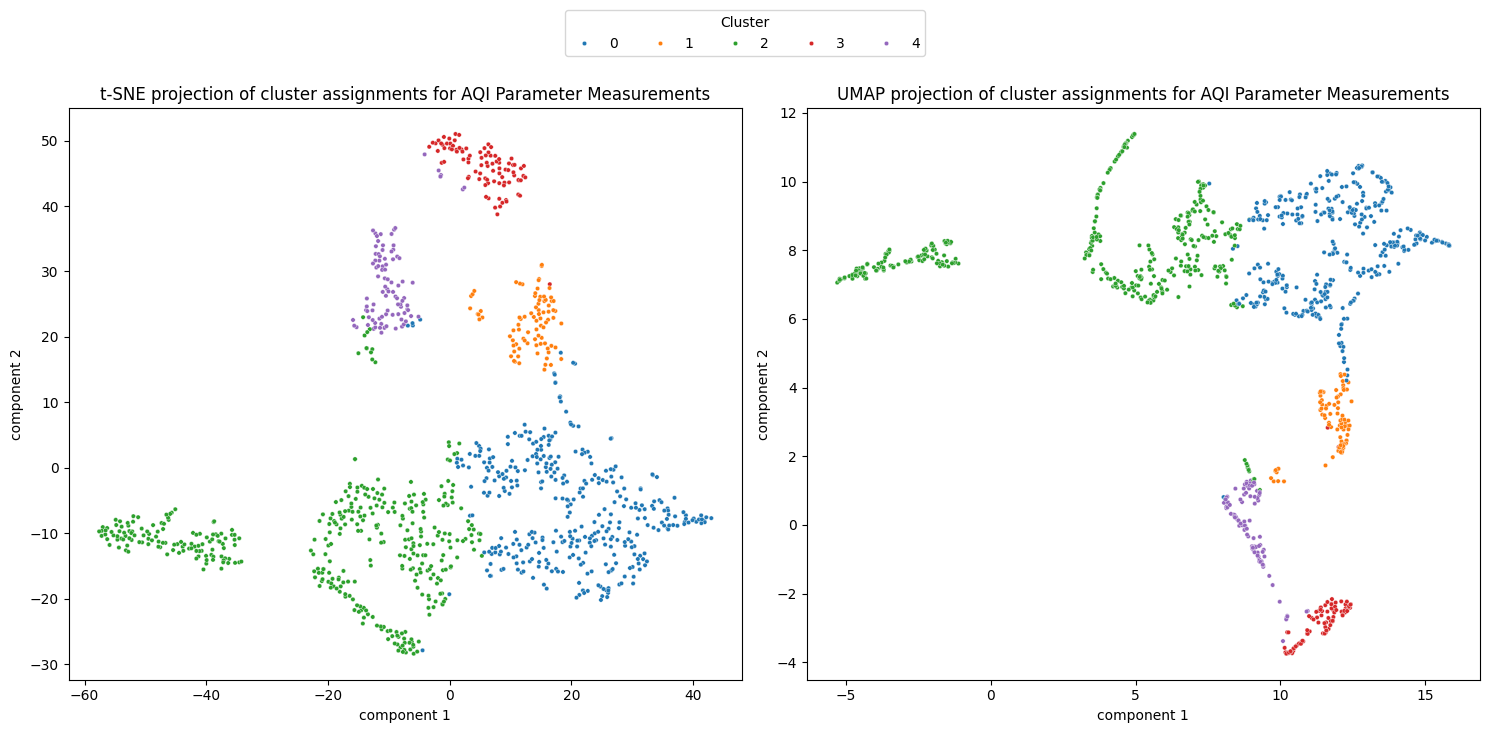

In [ ]:
plot_cluster_assignments(tsne_measurements_df, umap_measurements_df, measurements_standard['cluster_assignments'])

###8c. CLARA Clustering

The CLARA clustering algorithm is conceptually similar to K-means but with a notable difference. Instead of calculating cluster means, it uses a "medoid", which is a point within the cluster that serves as the cluster centroid. By using an actual point form the cluster as the cluster "center", CLARA permits the use of non-Euclidean distance metrics to determine the ideal clusters. Like K-means, the practitioner must set a number of clusters for the algorithm to work from but must also set the distance metric used by the algorithm. Like K-means and Agglomerative Clustering, we can look at different numbers of clusters and determine which is likely best based on silhouette score.

In [ ]:
# code from course clustering assignment
def evaluate_CLARA(df, metric='cosine', nclusts=(2,16)):
    silhouette_coefficients = []
    max_diameters = []
    for k in range(nclusts[0],nclusts[1]+1):
        ## Put your code below
        ## First compute the cluster assignmenets for the number of clusters, k
        if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
        temp_mod=CLARA(n_clusters=k, metric=metric)
        cluster_assignments = temp_mod.fit_predict(df)

        ## Compute and append the silhouette coefficeint to the list
        silhouette_coefficients.append(silhouette_score(df, cluster_assignments, metric=metric))

        ## Find the max diameter of the clusters
        ## First add the cluster assignment column to the data frame
        df['cluster_assignments'] = cluster_assignments
        max_diameters.append(find_max_diameter(df, metric=metric))

    ## Plot the results
    _, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(range(nclusts[0],nclusts[1]+1), max_diameters);
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Maximum cluster diameter')
    ax[0].set_title('Maximum cluster diameter vs. number of clusters')
    ax[1].plot(range(nclusts[0],nclusts[1]+1), silhouette_coefficients);
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Coefficients')
    ax[1].set_title('Silhouette coefficient vs. number of clusters')
    return pd.DataFrame({'NumberClusters':range(nclusts[0],nclusts[1]+1),
                         'ClusterDiameter':max_diameters ,
                         'SilhouetteCoefficient':silhouette_coefficients})

,NumberClusters,ClusterDiameter,SilhouetteCoefficient
0,2,1.941769,0.357871
1,3,1.917863,0.364863
2,4,1.687878,0.594938
3,5,1.650177,0.517850
4,6,1.673499,0.591540
5,7,1.567632,0.439503
6,8,1.233475,0.593496
7,9,1.544861,0.448697
8,10,1.233475,0.530336
9,11,1.387500,0.505911


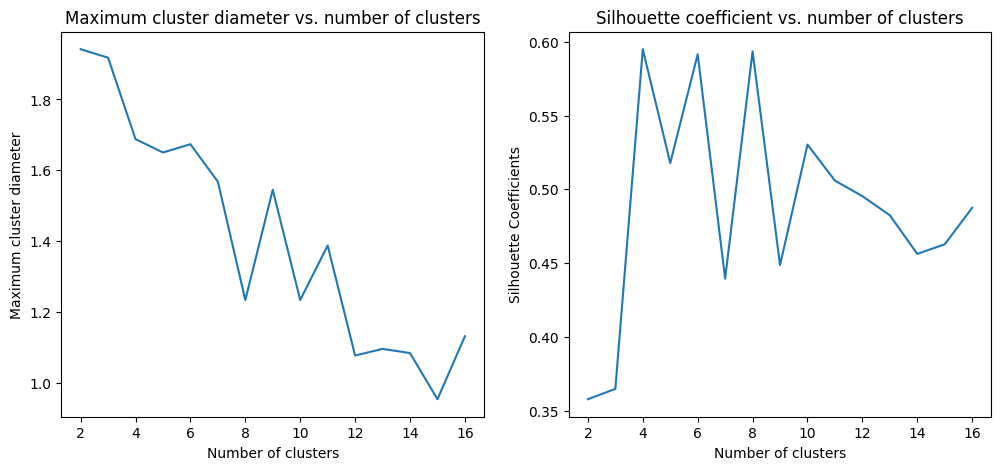

In [ ]:
evaluate_CLARA(measurements_standard.iloc[:,4:10])

Perhaps due the ability to use non-Euclidean distances, CLARA appears to have provided better clusters than K-means. 4, 6, and 8 clusters all have very similar silhouette scores, and after visualizing them all the option with 6 clusters seems to produce the best result when viewed in the t-SNE and UMAP projections, though this is likely quite subjective.

In [ ]:
#code from course clustering assignment
if 'cluster_assignments' in measurements_standard.columns: measurements_standard.drop(columns='cluster_assignments', inplace=True)
clara_model = CLARA(n_clusters=6, metric='cosine', random_state=4477).fit(measurements_standard.iloc[:,4:10])
measurements_standard['cluster_assignments'] = clara_model.labels_

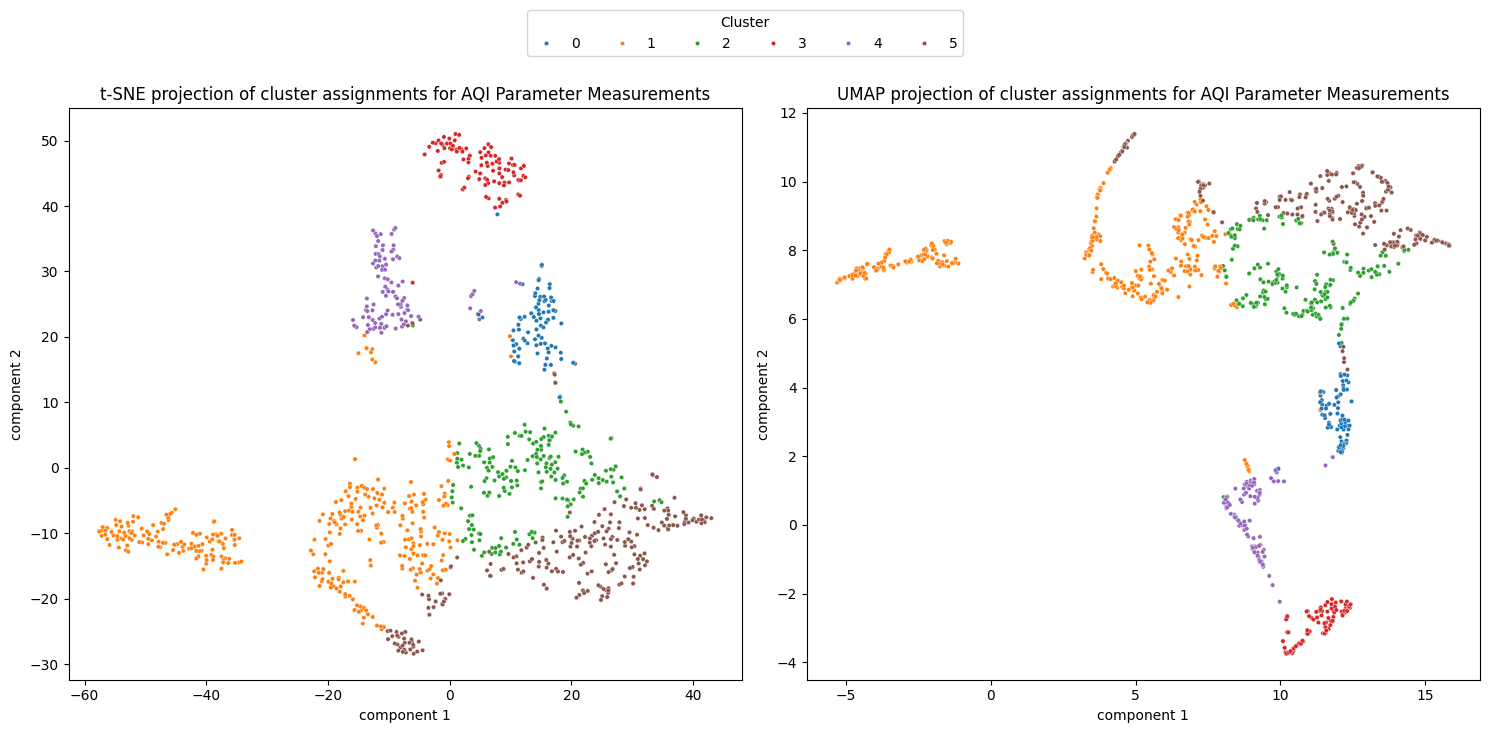

In [ ]:
plot_cluster_assignments(tsne_measurements_df, umap_measurements_df, measurements_standard['cluster_assignments'])

###8d. Spectral Clustering

Spectral clustering begins by building a graph of the data and then using the Graph Laplacian to determine how to split the graph. The graphs can be: 1) a nearest-neighbors graph with the n nearest neighbors to each node connected to it, with n as a hyperparameter, 2) a neighborhood graph where any nodes within a set distance are connected, with the distance as a hyperparameter, or 3) a fully connected graph, where all nodes are connected, with their edges weighted by their similarity. Like several of the other algorithms, we must set the number of clusters to divide the data into.

 I chose to use a nearest-neighbor graph and experimented with several values for the n nearest neighbors. I found that for lower values of n, fewer clusters were favored, with the number of clusters increasing once n got into values above 150. The highest silhouette scores I saw were for lower values of n, with the highest being for n=20 and the number of clusters equal to 3.

In [ ]:
# code adapted from course clustering assignment
def evaluate_SPECTRAL(df, nclusts=(2,16)):
    silhouette_coefficients = []
    max_diameters = []
    for k in range(nclusts[0],nclusts[1]+1):
        ## Put your code below
        ## First compute the cluster assignmenets for the number of clusters, k
        if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
        cluster_assignments = SpectralClustering(assign_labels='discretize', n_clusters=k, affinity='nearest_neighbors', n_neighbors=20, random_state=0).fit_predict(df)

        ## Compute and append the silhouette coefficeint to the list
        silhouette_coefficients.append(silhouette_score(df, cluster_assignments))

        ## Find the max diameter of the clusters
        ## First add the cluster assignment column to the data frame
        df['cluster_assignments'] = cluster_assignments
        max_diameters.append(find_max_diameter(df, metric='cosine'))

    ## Plot the results
    _, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(range(nclusts[0],nclusts[1]+1), max_diameters);
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Maximum cluster diameter')
    ax[0].set_title('Maximum cluster diameter vs. number of clusters')
    ax[1].plot(range(nclusts[0],nclusts[1]+1), silhouette_coefficients);
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Coefficients')
    ax[1].set_title('Silhouette coefficient vs. number of clusters')
    return pd.DataFrame({'NumberClusters':range(nclusts[0],nclusts[1]+1),
                         'ClusterDiameter':max_diameters ,
                         'SilhouetteCoefficient':silhouette_coefficients})

,NumberClusters,ClusterDiameter,SilhouetteCoefficient
0,2,1.991257,0.237011
1,3,1.949320,0.297111
2,4,1.831069,0.192461
3,5,1.883773,0.227452
4,6,1.810865,0.226380
5,7,1.757366,0.198083
6,8,1.824788,0.142753
7,9,1.609991,0.176542
8,10,1.509460,0.167342
9,11,1.520007,0.189429


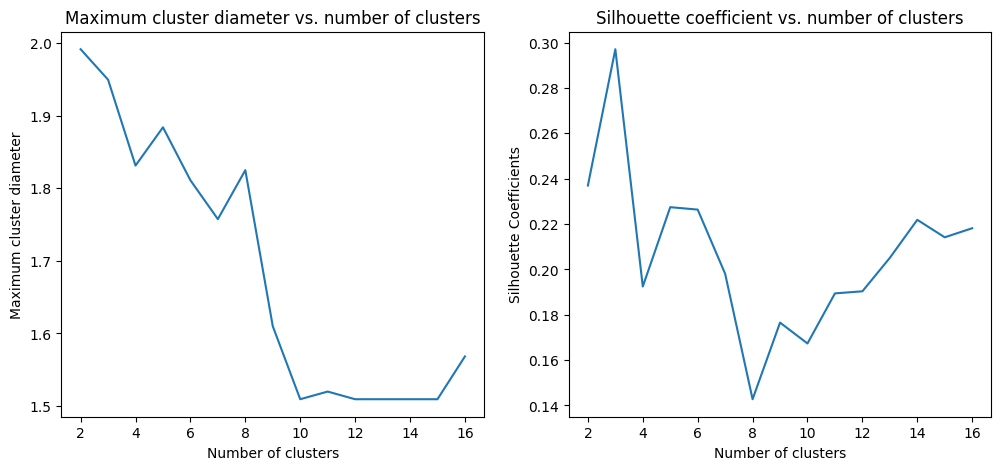

In [ ]:
evaluate_SPECTRAL(measurements_standard.iloc[:,4:10])

In [ ]:
#code from course clustering assignment
nr.seed(7788)
if 'cluster_assignments' in measurements_standard.columns: measurements_standard.drop(columns='cluster_assignments', inplace=True)
measurements_standard['cluster_assignments']  = SpectralClustering(assign_labels='discretize', n_clusters=3, affinity='nearest_neighbors', n_neighbors=20, random_state=0).fit_predict(measurements_standard.iloc[:,4:10])


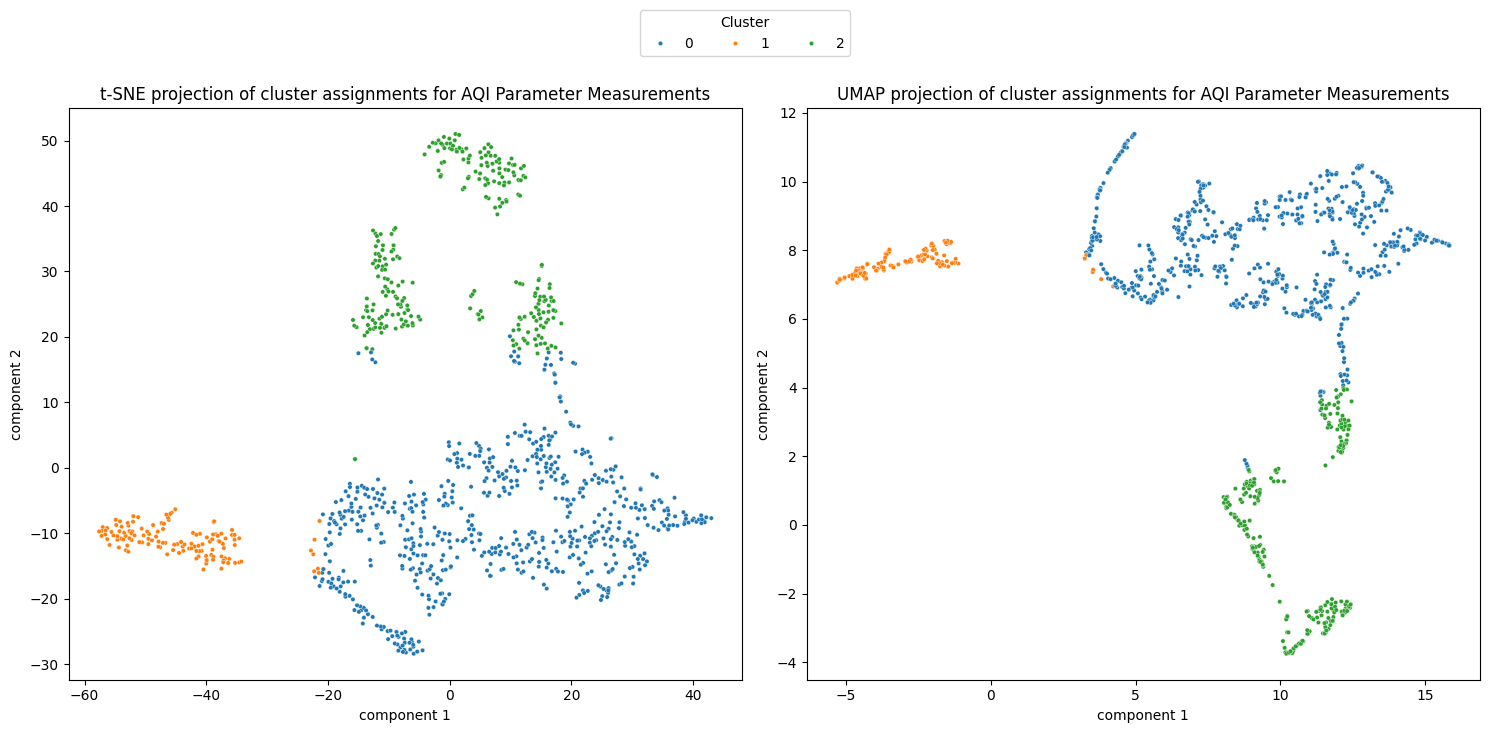

In [ ]:
plot_cluster_assignments(tsne_measurements_df, umap_measurements_df, measurements_standard['cluster_assignments'])

###8e. OPTICS Clustering

OPTICS is a density-based clustering approach that uses the concept of core points that determine a cluster around high-density areas of core points and reachable points that are part of a core point's cluster if they are close to a core point or to other points that are close to a core point. In terms of hyperparameters, the algorithm requires that we set the minimum number of samples required for a point to be a core point and to decide on a distance metric. The algorithm leaves open the possibility that for a certain set of hyperparameters, points will be unreachable from any core point and so they will not be assigned to any cluster. In adjusting the hyperparameters I found that a min_samples of 50 and cosine distance produced nice clusters with the greatest number of points (734, 71% of total) assigned to a cluster.

In [ ]:
#code from course clustering assignment
nr.seed(4512)
if 'cluster_assignments' in measurements_standard.columns: measurements_standard.drop(columns='cluster_assignments', inplace=True)
optics_model = OPTICS(min_samples=50, metric='cosine').fit(measurements_standard.iloc[:,4:10])

measurements_standard['cluster_assignments'] = optics_model.labels_

measurements_temp = measurements_standard[measurements_standard.cluster_assignments > -1]

The t-SNE and UMAP plots only show points assigned to clusters.

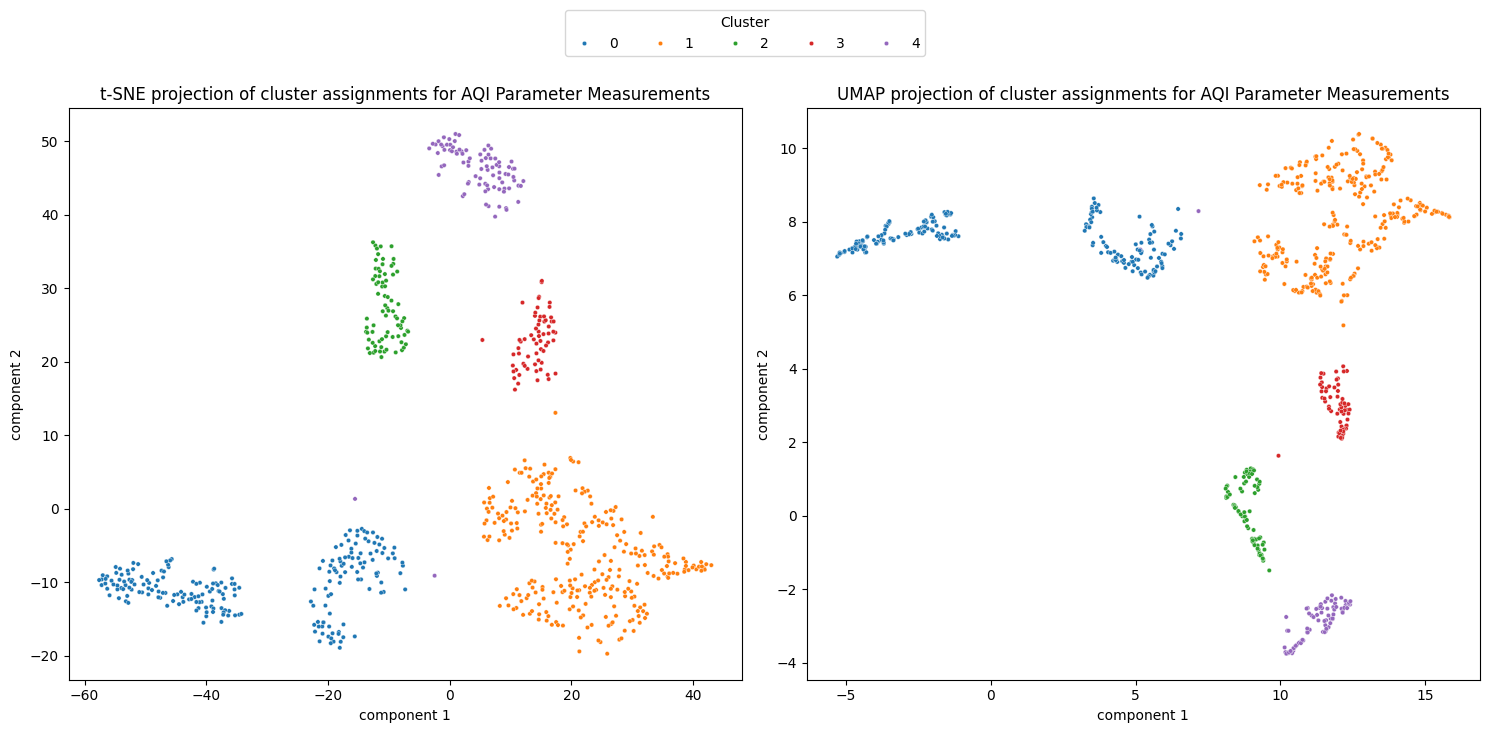

In [ ]:
plot_cluster_assignments(tsne_measurements_df, umap_measurements_df, measurements_temp['cluster_assignments'])

In [ ]:
len(measurements_standard[measurements_standard.cluster_assignments > -1])

743

In [ ]:
len(measurements_standard[measurements_standard.cluster_assignments <= -1])

301

In [ ]:
len(measurements_standard[measurements_standard.cluster_assignments > -1]) / 1044

0.7116858237547893

###9. Conclusion

The clustering algorithm and number of clusters that seemed to produce the best results, both in terms of having the highest silhouette score, and in terms of the t-SNE and UMAP plots, was Agglomerative Clustering with 5 clusters. Looking at the plots we see 5 clusters that seem to make up distinct areas of the lower-dimensional representation. While we can't view this in 6 dimensions, the hope is that in 6 dimensions the clusters would be even better separated.

In [ ]:
# code adapdted from course clustering assignment
nr.seed(2356)
if 'cluster_assignments' in measurements_standard.columns: measurements_standard.drop(columns='cluster_assignments', inplace=True)
model_agglomerative =  AgglomerativeClustering(n_clusters=5, linkage='average', metric='cosine',
                                              compute_full_tree=False)
measurements_standard['cluster_assignments'] = model_agglomerative.fit_predict(measurements_standard.iloc[:,4:10])


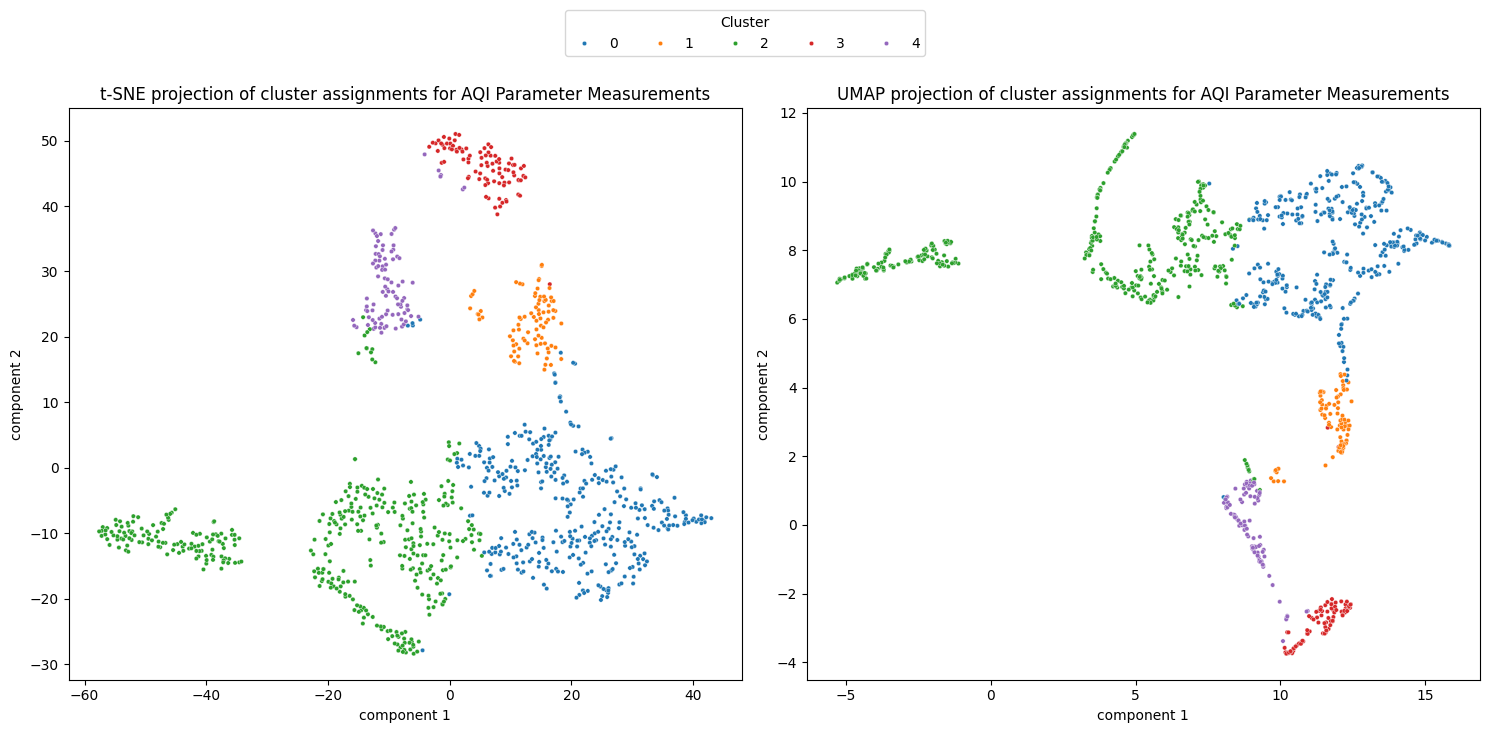

In [ ]:
plot_cluster_assignments(tsne_measurements_df, umap_measurements_df, measurements_standard['cluster_assignments'])

By looking at the median un-normalized values for the 6 AQI parameters when we group by the 5 clusters, we can pick out differences between many of the clusters.

For example, when we look at the 2 largest clusters, cluster 0 and cluster 2, we see that cluster 0 has higher pollution values for all parameters and has the worst overall values for PM 2.5 and PM10 of any cluster.

Clusters 1 and 3 have very similar values except their values for NO2 (Nitrogen Dioxide) and O3 (Ozone) seem to be swapped, with cluster 1 showing high NO2 and lower O3 and cluster 3 showing the opposite.

Clusters 3 and 4 are also similar except for a similar swap of their values for O3 (Ozone) and SO2 (Sulphur Dioxide).

Cluster 2 is the healthiest cluster, with the lowest pollution values for all parameters across all clusters.

Looking at specific countries and clusters, we can see that South Korea has more locations in cluster 0 (247), the "unhealthier" cluster, than it does in the cluster 2 (153), the "healthier" cluster. Spain on the other hand has only 1 location in cluster 0 but 30 in cluster 2.

This analysis shows that we can use clustering to find similar locations around the globe in terms of their air quality and points to the ability to perform intertemporal clustering to compare how locations have shifted in terms of their pollution profile over time.


In [ ]:
measurements_df['cluster_assignments'] = measurements_standard['cluster_assignments']

In [ ]:
median_values = measurements_df.loc[:,['pm25','pm10', 'no2', 'o3', 'so2', 'co','cluster_assignments', 'location']]
grouped_median = median_values.groupby('cluster_assignments').agg({'pm25':'median','pm10':'median','no2':'median','o3':'median','so2':'median','co':'median','location':'count'})

In [ ]:
grouped_median

,pm25,pm10,no2,o3,so2,co,location
cluster_assignments,,,,,,,
0,21.789474,55.025641,0.012620,0.035848,0.002215,0.383093,367
1,17.251295,45.987399,0.148769,0.038981,0.002427,0.380709,86
2,14.046691,29.802480,0.008763,0.033262,0.001906,0.346198,406
3,19.323009,50.844359,0.014833,0.184083,0.002313,0.412924,91
4,18.859628,50.239802,0.015310,0.037977,0.125786,0.390281,94


In [ ]:
grouped_median.iloc[:,:-1].median(axis=0)

pm25    18.859628
pm10    50.239802
no2      0.014833
o3       0.037977
so2      0.002313
co       0.383093
dtype: float64

In [ ]:
measurements_df[measurements_df['cluster_assignments'] == 0].sort_values(by='pm10', ascending=False).head(10)

,locationId,location,latitude,longitude,co,no2,o3,pm10,pm25,so2,country_code,country_name,cluster_assignments
198,10636,Instituto Educativo,21.903278,-102.276111,24225.880404,0.021424,0.125903,986.228333,19.955497,0.000432,MX,Mexico,0
202,10713,San Pedro,25.665278,-100.412778,3.217500,0.017088,0.049293,168.642857,18.821429,0.005051,MX,Mexico,0
218,225567,Maesai Health Office,20.427325,99.883842,1.146536,0.021000,0.031625,148.753108,104.210480,0.000280,MM,Myanmar,0
244,351927,Le Thai Community Park,17.006059,99.819270,0.395379,0.003630,0.033697,113.437276,61.565771,0.000122,TH,Thailand,0
241,235231,Almoloya de Juárez,19.370439,-99.752750,0.000000,0.018468,0.042723,108.127660,52.021277,0.004891,MX,Mexico,0
240,235227,Calimaya,19.192694,-99.586167,0.829333,0.014989,0.032500,95.762500,38.325000,0.002340,MX,Mexico,0
197,10629,Estación de Bomberos de Cd. Sahagún,19.771694,-98.577694,0.641836,0.008261,0.024902,90.880000,28.736842,0.002293,MX,Mexico,0
212,10862,Velódromo,19.115858,-98.277487,0.631227,0.023268,0.031756,90.216715,30.160654,0.001521,MX,Mexico,0
208,10818,Secretaría de Medio Ambiente,21.845250,-102.291250,0.868317,0.020268,0.021631,89.046512,17.923214,0.001204,MX,Mexico,0
210,10852,Biblioteca,19.840583,-98.981333,1.111391,0.018501,0.036864,84.559095,23.684680,0.003416,MX,Mexico,0


In [ ]:
measurements_df[measurements_df['cluster_assignments'] == 0].country_name.value_counts()

country_name
South Korea    247
Taiwan          36
Mexico          23
Thailand        22
Serbia          10
Poland           8
China            6
Macedonia        3
North Korea      3
Peru             2
Hungary          2
Vietnam          2
Myanmar          1
Laos             1
Spain            1
Name: count, dtype: int64

In [ ]:
measurements_df[measurements_df['cluster_assignments'] == 2].sort_values(by='pm10', ascending=False).head(10)

,locationId,location,latitude,longitude,co,no2,o3,pm10,pm25,so2,country_code,country_name,cluster_assignments
179,9329,García,25.783333,-100.585833,2.023797,0.003677,0.047797,74.050633,8.366197,0.003996,MX,Mexico,2
166,8168,Cadereyta,25.600556,-99.994167,2.192990,0.009057,0.040979,72.103093,13.554348,0.007141,MX,Mexico,2
213,10876,Escobedo,25.800556,-100.344444,0.471957,0.012645,0.042630,61.494505,11.595238,0.003402,MX,Mexico,2
154,7976,Pueblo Serena,25.575278,-100.249167,1.174118,0.012442,0.048120,60.282609,14.974359,0.003284,MX,Mexico,2
173,8662,La Pastora,25.668056,-100.249444,2.619341,0.017586,0.042626,59.725275,14.236232,0.004598,MX,Mexico,2
1037,2624054,석사동,37.856977,127.750062,1.223852,0.007537,0.035232,54.526495,14.119950,0.001756,KR,South Korea,2
827,2623405,인천 북항,37.496332,126.643072,0.348851,0.020702,0.029511,53.550170,14.465753,0.038844,KR,South Korea,2
201,10710,San Nicolás,25.745278,-100.255000,3.161655,0.011869,0.040765,53.272727,14.098214,0.004930,MX,Mexico,2
927,2623601,단양읍,36.987924,128.364813,0.557804,0.009819,0.038022,51.762712,16.564655,0.001890,KR,South Korea,2
481,2622752,파주읍,37.830900,126.833000,0.411872,0.008666,0.034984,51.650919,15.642534,0.001373,KR,South Korea,2


In [ ]:
measurements_df[measurements_df['cluster_assignments'] == 2].country_name.value_counts()

country_name
South Korea                 153
Spain                        63
United States of America     30
Taiwan                       29
Hungary                      18
Serbia                       18
Mexico                       11
Germany                      11
Poland                        8
Kosovo                        7
Italy                         7
Austria                       6
China                         5
Belgium                       5
Cyprus                        5
Czechia                       4
Portugal                      3
Macedonia                     3
Peru                          3
Canada                        3
Greece                        2
Lithuania                     2
Bulgaria                      2
France                        2
Thailand                      2
Slovakia                      1
Luxembourg                    1
Argentina                     1
United Kingdom                1
Name: count, dtype: int64